# Transfer learning: classifying food items

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image
import time

import tensorflow as tf

## Get data

We are going to use the [Food-11 dataset](https://www.epfl.ch/labs/mmspg/downloads/food-image-datasets/), from the EPFL Multimedia Signal Processing Group. Here's a description:

> This is a dataset containing 16643 food images grouped in 11 major food categories. The 11 categories are Bread, Dairy product, Dessert, Egg, Fried food, Meat, Noodles/Pasta, Rice, Seafood, Soup, and Vegetable/Fruit. Similar as Food-5K dataset, the whole dataset is divided in three parts: training, validation and evaluation. The same naming convention is used, where ID 0-10 refers to the 11 food categories respectively.
>
> The total file size of the Food-11 dataset is about 1.16 GB.



In [ ]:
classes = np.array(["Bread", "Dairy product", "Dessert", "Egg", "Fried food",
	"Meat", "Noodles/Pasta", "Rice", "Seafood", "Soup",
	"Vegetable/Fruit"])

In [ ]:
!mkdir -p /content/Food-11
%cd /content/Food-11
# !gdown https://drive.google.com/uc?id=1dt3CD3ICdLbTf80sNJ25TPBDKu_qyCnq
!gdown https://drive.google.com/uc?id=1-5Zo4mpQRglZ6IAgHadiUrZqOPMPqfZI

/content/Food-11
Downloading...
From: https://drive.google.com/uc?id=1-5Zo4mpQRglZ6IAgHadiUrZqOPMPqfZI
To: /content/Food-11/Food-11.zip
100% 1.16G/1.16G [00:14<00:00, 80.8MB/s]


In [ ]:
!unzip Food-11.zip

Streaming output truncated to the last 5000 lines.
  inflating: training/2_787.jpg      
  inflating: training/2_924.jpg      
  inflating: training/5_453.jpg      
  inflating: training/10_212.jpg     
  inflating: training/9_962.jpg      
  inflating: training/3_433.jpg      
  inflating: training/3_922.jpg      
  inflating: training/1_359.jpg      
  inflating: training/5_1145.jpg     
  inflating: training/5_204.jpg      
  inflating: training/5_1046.jpg     
  inflating: training/7_160.jpg      
  inflating: training/10_635.jpg     
  inflating: training/0_879.jpg      
  inflating: training/9_313.jpg      
  inflating: training/1_131.jpg      
  inflating: training/10_448.jpg     
  inflating: training/9_1110.jpg     
  inflating: training/8_230.jpg      
  inflating: training/5_731.jpg      
  inflating: training/0_151.jpg      
  inflating: training/2_984.jpg      
  inflating: training/2_1335.jpg     
  inflating: training/4_745.jpg      
  inflating: training/6_236.jpg      

In [ ]:
%cd /content

/content


Click on the folder icon in Colab to view your filesystem and verify that you have the `Food-11` directory with `training`, `validation`, and `evaluation` subdirectories.

In [ ]:
training_dir = "Food-11/training/"
training_images = os.listdir(training_dir)
training_labels = np.array([int(f.split('_')[0]) for f in training_images ])

In [ ]:
validation_dir = "Food-11/validation/"
validation_images = os.listdir(validation_dir)
validation_labels = np.array([int(f.split('_')[0]) for f in validation_images ])

In [ ]:
evaluation_dir = "Food-11/evaluation/"
evaluation_images = os.listdir(evaluation_dir)
evaluation_labels = np.array([int(f.split('_')[0]) for f in evaluation_images ])

Let's look at a few random training samples:

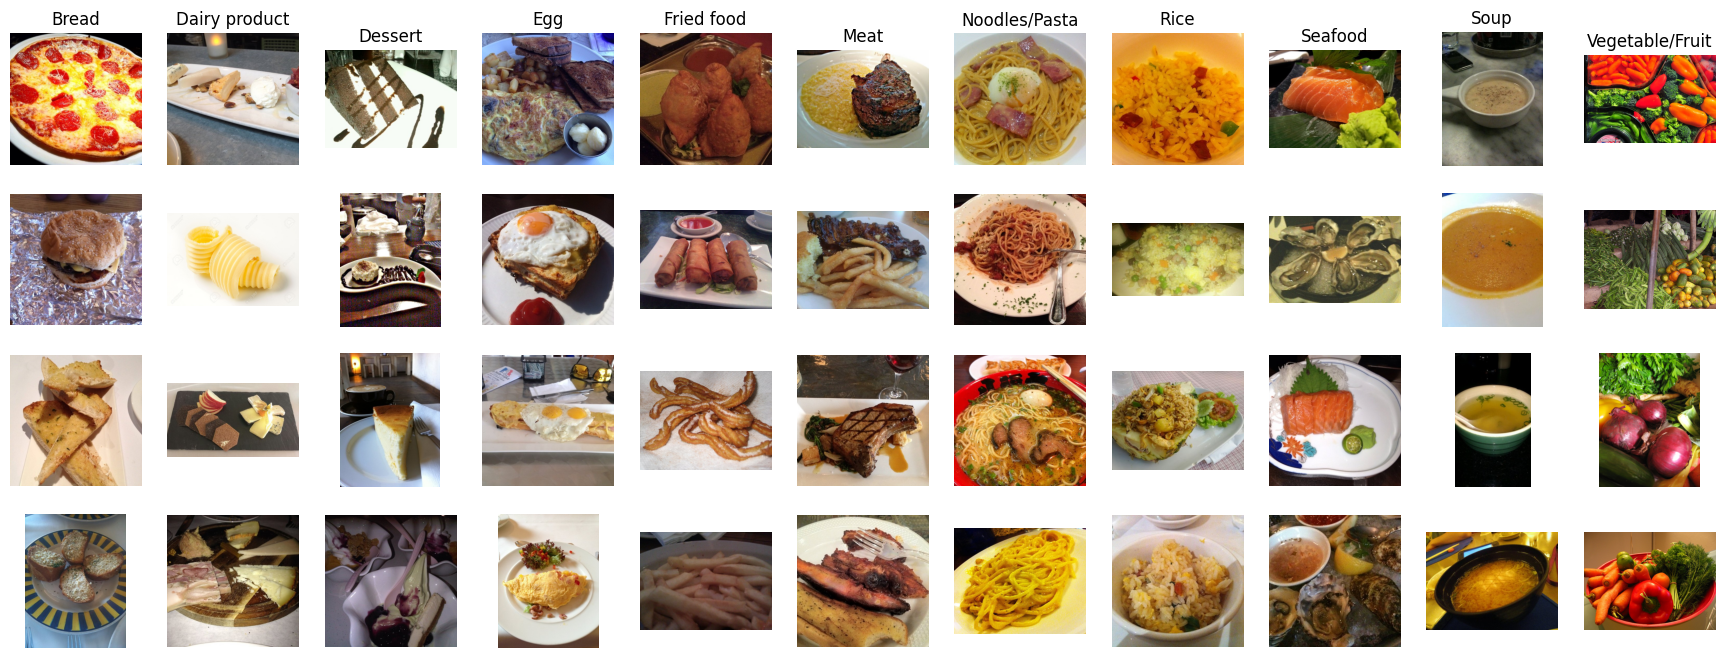

In [ ]:
num_classes = len(classes)
samples_per_class = 4
figure = plt.figure(figsize=(num_classes*2,samples_per_class*2))
for cls_idx, cls in enumerate(classes):
  idxs = np.flatnonzero(training_labels == cls_idx)
  idxs = np.random.choice(idxs, samples_per_class, replace=False)
  for i, idx in enumerate(idxs):
    plt_idx = i * num_classes + cls_idx + 1
    plt.subplot(samples_per_class, num_classes, plt_idx)
    im = Image.open(training_dir + training_images[idx])
    plt.imshow(im)
    plt.axis('off')
    if i == 0:
      plt.title(cls)
plt.show()

We can see that two dessert samples (for example) may look very different from one another - intra-class variability. Furthermore, samples from two different classes, such as a rice dish and a noodles dish, may look very similar to one another - inter-class similarity.

(In fact, some foods may really belong to multiple classes.  For example, fried chicken should really have both the "fried food" and "meat" labels, but only one class label is provided for each sample in the dataset.)

## Prepare data directories

Because the Food-11 dataset is very large, we won't want to load the entire dataset into memory at once.

Instead, Keras will let us read in images from disk as they are needed (in batches). For this to work, Keras [expects](https://keras.io/api/preprocessing/) that images will be organized in the following directory structure, with one subdirectory per class:

```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```

So, we will have to re-organize our directory structure to match.

In [ ]:
%cd /content/Food-11/training/

# loop over classes
for i in range(len(classes)):
  # make a directory for this class inside Food-11/training
  try:
    os.mkdir("class_%02d" % i)
  except FileExistsError:
    pass
  # get list of files inside Food-11/training that have this class label
  files = [f for f in os.listdir('/content/Food-11/training/') if f.startswith("%d_" % i)]
  # move each file to the subdirectory for the class
  for f in files:
    shutil.move(f, "class_%02d/" % i)

/content/Food-11/training


In [ ]:
%cd /content/Food-11/validation/

for i in range(len(classes)):
  try:
    os.mkdir("class_%02d" % i)
  except FileExistsError:
    pass
  files = [f for f in os.listdir('/content/Food-11/validation/') if f.startswith("%d_" % i)]
  for f in files:
    shutil.move(f, "class_%02d/" % i)

/content/Food-11/validation


In [ ]:
%cd /content/Food-11/evaluation/

for i in range(len(classes)):
  try:
    os.mkdir("class_%02d" % i)
  except FileExistsError:
    pass
  files = [f for f in os.listdir('/content/Food-11/evaluation/') if f.startswith("%d_" % i)]
  for f in files:
    shutil.move(f, "class_%02d/" % i)

/content/Food-11/evaluation


In [ ]:
# go back to default working directory
%cd /content

/content


Use the folder icon in Colab to look at your directory structure, and verify that within the training, validation, and evaluation data directories, there are subdirectories for each class containing the samples from that class.

## Prepare data generators

Now that we have prepared the directory structure, we can set up our data "flow".

In the next cell, I have defined a batch size and an image size. You are free to change these parameters, or you can keep them. You can use any batch size that has good results in training, and you can change the input image size to match the input shape of whatever base model you are using.

In [ ]:
# TODO 1 (optional) - design choice on batch size, image shape
BATCH_SIZE=32
INPUT_IMG_SIZE = 224

Then, I have defined some data generators to create augmented samples (slightly changed versions of the original samples). You are free to change the transformations used to generate the augmented data. You can learn more about the image transformations in the [ImageDataGenerator documentation](https://keras.io/api/preprocessing/image/#imagedatagenerator-class).

After we define the data generator, we use  `flow_from_directory` to get images off the disk during training, on an as-needed basis.

In [ ]:
# TODO 2 (optional) - design choices on image transformations for data augmentation

# prepare ImageDataGenerator to create augmented training samples
training_aug = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale=1.0/255,          # rescales so each pixel is in 0-1 range
	rotation_range=1,
	zoom_range=0.1,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.1,
	horizontal_flip=True,
	fill_mode="nearest")

# prepare generator that pulls images from directory (and resizes)
training_gen = training_aug.flow_from_directory(
	'/content/' + training_dir,
	target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE),
	color_mode="rgb",
	shuffle=True,
	batch_size=BATCH_SIZE,
  class_mode='sparse')

Found 9866 images belonging to 11 classes.


Check the mapping of directory names to class labels:

In [ ]:
training_gen.class_indices

{'class_00': 0,
 'class_01': 1,
 'class_02': 2,
 'class_03': 3,
 'class_04': 4,
 'class_05': 5,
 'class_06': 6,
 'class_07': 7,
 'class_08': 8,
 'class_09': 9,
 'class_10': 10}

We also set up the validation and evaluation (test) sets in a similar manner:

In [ ]:
validation_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255
)

validation_gen = validation_aug.flow_from_directory(
	'/content/' + validation_dir,
	target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE),
	color_mode="rgb",
	shuffle=True,
	batch_size=BATCH_SIZE,
  class_mode='sparse')

Found 3430 images belonging to 11 classes.


Don't shuffle the evaluation set:

In [ ]:
evaluation_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255
)

evaluation_gen = evaluation_aug.flow_from_directory(
	'/content/' + evaluation_dir,
	target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE),
	color_mode="rgb",
	shuffle=False,
	batch_size=BATCH_SIZE,
  class_mode='sparse')

Found 3347 images belonging to 11 classes.


## Evaluating previous Model

In [ ]:
previous_model = tf.keras.models.load_model('/content/drive/MyDrive/model.keras')
previous_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 11)                14091     
                                                                 
Total params: 2272075 (8.67 MB)
Trainable params: 14091 (55.04 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
previous_model_metrics = previous_model.evaluate(evaluation_gen)

105/105 [==============================] - 179s 2s/step - loss: 0.7037 - accuracy: 0.7622


In [ ]:
y_pred_prob = previous_model.predict(evaluation_gen)
y_pred = np.argmax(y_pred_prob, axis=1)

105/105 [==============================] - 183s 2s/step


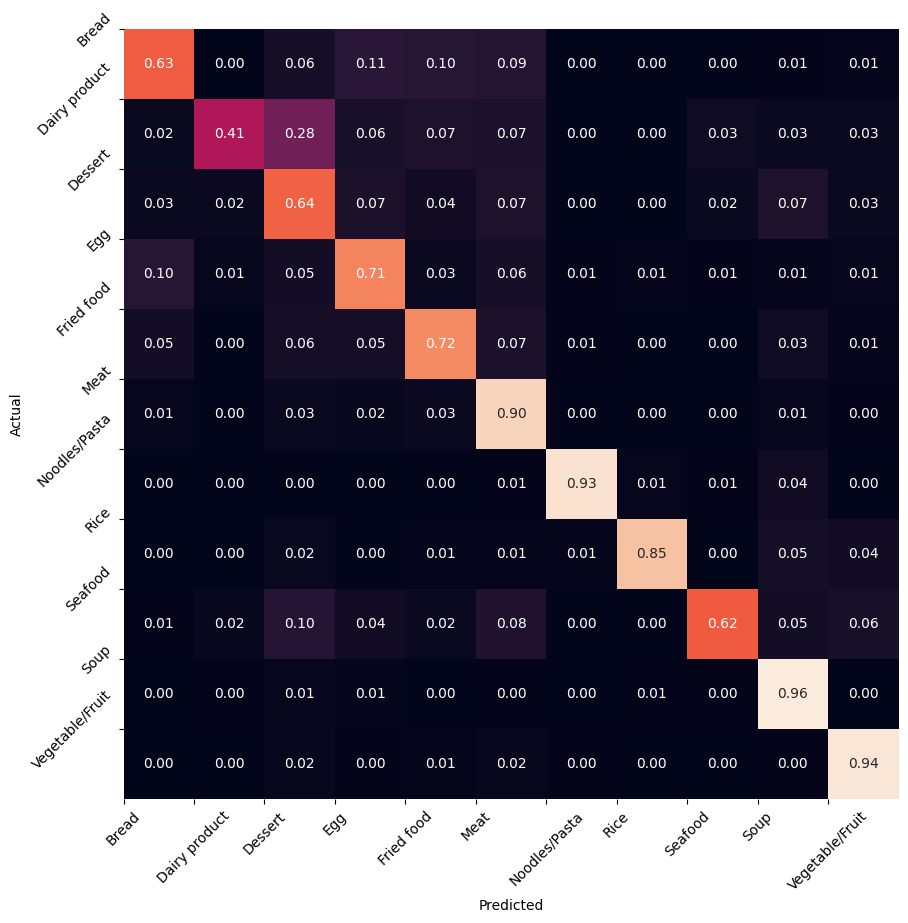

In [ ]:
cm = pd.crosstab(evaluation_gen.classes, y_pred,
                               rownames=['Actual'], colnames=['Predicted'],
                               normalize='index')
p = plt.figure(figsize=(10,10));
p = sns.heatmap(cm, annot=True, fmt=".2f", cbar=False);
p = plt.xticks(ticks=np.arange(0,11), labels=classes, rotation=45)
p = plt.yticks(ticks=np.arange(0,11), labels=classes, rotation=45)

## Prepare data generators for new model

In [ ]:
# Changing image transformations for data augmentation

# prepare ImageDataGenerator to create augmented training samples
# Using a different preprocessing function specifically meant for ResNet
training_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input
)

validation_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input
)

evaluation_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input
)

# prepare generator that pulls images from directory (and resizes)
training_gen = training_aug.flow_from_directory(
	'/content/' + training_dir,
	target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE),
	color_mode="rgb",
	shuffle=True,
	batch_size=BATCH_SIZE,
  class_mode='sparse')

validation_gen = validation_aug.flow_from_directory(
	'/content/' + validation_dir,
	target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE),
	color_mode="rgb",
	shuffle=True,
	batch_size=BATCH_SIZE,
  class_mode='sparse')

evaluation_gen = evaluation_aug.flow_from_directory(
	'/content/' + evaluation_dir,
	target_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE),
	color_mode="rgb",
	shuffle=False,
	batch_size=BATCH_SIZE,
  class_mode='sparse')

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


## Prepare base model

Now that the data is ready, we need to prepare the model.


First, review the models available as [Keras Applications](https://keras.io/api/applications/), and decide which model you will use. Make sure to click through from the table to the model documentation, to learn more about each model you are considering.

In the cell that follows, I have used the [VGG16](https://keras.io/api/applications/vgg/) model, but you can change that - you may use any model that you think will have good results.

In [ ]:
# TODO 3 (optional) - design choice on base model

base_model = tf.keras.applications.ResNet50V2(
  input_shape=(INPUT_IMG_SIZE,INPUT_IMG_SIZE,3),
  include_top=False,
  pooling='avg'
)

94668760/94668760 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

## Train model with new classification head

In the following cell, "freeze" your base model (set it so that it is not trainable), and then construct a new model using the frozen base model with a new classification head.  (You can add a dropout layer in between if you think it will be helpful.)

(You can refer to this week's demo notebook for an example.)

In [ ]:
# TODO 4 (required) - prepare model with new classification head
base_model.trainable = False

model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(
    units=11,
    activation=tf.keras.activations.softmax
))

Then, print a model summary:

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 11)                22539     
                                                                 
Total params: 23587339 (89.98 MB)
Trainable params: 22539 (88.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


(Make sure that most parameters are "non-trainable", because you have frozen the base model!)

Compile your model with an appropriate optimizer and loss function, and use accuracy as a metric.

In [ ]:
# TODO 5 (required) - design training parameters, and compile
# The default learning rate for "Adam" optimizer is 0.01
model.compile(
    optimizer="Adam",
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

Finally, fit your model with the new classification head for as many epochs as you think is appropriate. You may also use early stopping if you think it will be helpful.

Pass the validation data generator as `validation_data`.

(You can refer to this week's demo notebook for an example.)

In [ ]:
# TODO 6 (required) - fit model, you decide how many epochs
# note: you can get the number of training samples with training_gen.n
# and the number of validation samples with validation_gen.n
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]

n_epochs = 20
start_time = time.time()

hist = model.fit(training_gen, epochs=n_epochs, validation_data=validation_gen, callbacks=callback)

print('Convergence time', time.time() - start_time)

Epoch 1/20
309/309 [==============================] - 66s 202ms/step - loss: 1.1793 - accuracy: 0.6232 - val_loss: 0.6634 - val_accuracy: 0.7819
Epoch 2/20
309/309 [==============================] - 54s 176ms/step - loss: 0.7373 - accuracy: 0.7620 - val_loss: 0.6020 - val_accuracy: 0.8064
Epoch 3/20
309/309 [==============================] - 61s 197ms/step - loss: 0.6451 - accuracy: 0.7913 - val_loss: 0.6025 - val_accuracy: 0.8047
Epoch 4/20
309/309 [==============================] - 55s 177ms/step - loss: 0.6050 - accuracy: 0.7986 - val_loss: 0.5894 - val_accuracy: 0.8070
Epoch 5/20
309/309 [==============================] - 56s 181ms/step - loss: 0.5867 - accuracy: 0.8041 - val_loss: 0.5803 - val_accuracy: 0.8181
Epoch 6/20
309/309 [==============================] - 56s 179ms/step - loss: 0.5545 - accuracy: 0.8158 - val_loss: 0.5645 - val_accuracy: 0.8175
Epoch 7/20
309/309 [==============================] - 60s 196ms/step - loss: 0.5450 - accuracy: 0.8170 - val_loss: 0.5538 - val_ac

In [ ]:
model_metrics = model.evaluate(evaluation_gen)

105/105 [==============================] - 15s 147ms/step - loss: 0.5269 - accuracy: 0.8282


Plot the training history. In one subplot, show loss vs. epoch for the training and validation sets on the same plot. In the second subplot, show accuracy vs. epoch for the training and validation sets on the same plot.

Make sure you show the training history from the *beginning* of training. (If you re-run the `hist = fit(...)` command, you'll overwrite the previous history and lose the training history from the beginning, so be careful not to do that in your final submission!)

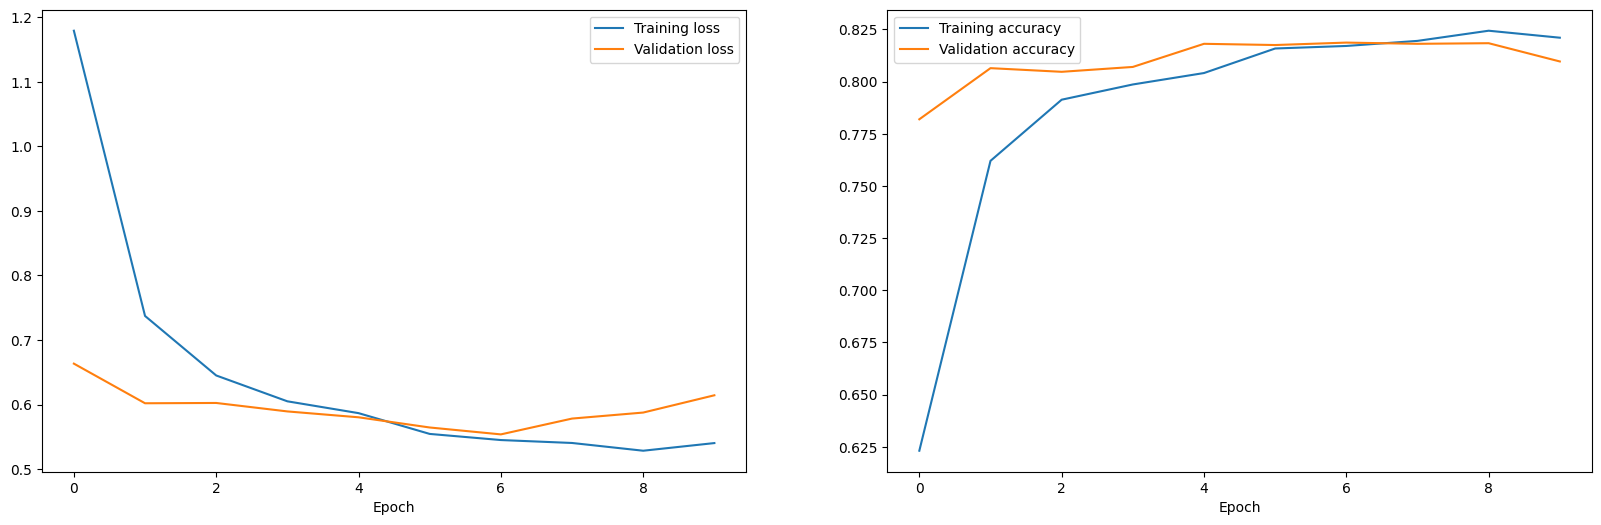

In [ ]:
# TODO 7 (required) - plot training history
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

sns.lineplot(x=range(len(hist.history['loss'])), y=hist.history['loss'], ax=axes[0], label='Training loss').set(xlabel='Epoch');
sns.lineplot(x=range(len(hist.history['val_loss'])), y=hist.history['val_loss'], ax=axes[0], label='Validation loss').set(xlabel='Epoch');


sns.lineplot(x=range(len(hist.history['accuracy'])), y=hist.history['accuracy'], ax=axes[1], label='Training accuracy').set(xlabel='Epoch');
sns.lineplot(x=range(len(hist.history['val_accuracy'])), y=hist.history['val_accuracy'], ax=axes[1], label='Validation accuracy').set(xlabel='Epoch');

## Fine-tune model

Next, we are going to "un-freeze" the later layers of the model, and train it for a few more epochs on our data (with a smaller learning rate), so that it is better suited for our specific classification task.

Note that you should *not* create a new model. We're just going to continue training the model we already started training.

First, we will un-freeze the base model:

In [ ]:
base_model.trainable = True

Then, we will re-freeze only the first layers of the base model. In the cell below, I have left the last five layers, which includes the last set of convolutional filters, unfrozen. But you are free to change this number if you think you will get better performance.

In [ ]:
# TODO 8 (optional) - you can decide how many layers to unfreeze

for layer in base_model.layers[:-5]:
	layer.trainable = False

The output of the following cell will indicate which layers in the base model are trainable, and which are not:

In [ ]:
for layer in base_model.layers:
  print("{}: {}".format(layer, layer.trainable))

<keras.src.engine.input_layer.InputLayer object at 0x7b5ac211f0a0>: False
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7b5a841df7c0>: False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b5a8435b970>: False
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7b5a7c0aaef0>: False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7b5a7c1ea470>: False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7b5a686cfe80>: False
<keras.src.layers.core.activation.Activation object at 0x7b5a8453bcd0>: False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b5a900ed870>: False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7b5a686cfdf0>: False
<keras.src.layers.core.activation.Activation object at 0x7b5a7c1ea620>: False
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7b5a686edc00>: False
<keras.src.layers.convolutional.conv2d.Conv2D ob

Also, the model summary should now show more trainable parameters:

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 11)                22539     
                                                                 
Total params: 23587339 (89.98 MB)
Trainable params: 1077259 (4.11 MB)
Non-trainable params: 22510080 (85.87 MB)
_________________________________________________________________


Re-compile your model. Don't forget to use a smaller learning rate for fine-tuning! We don't want to make major changes to the last feature extraction layers, we just want to adjust them a little bit.

In [ ]:
# TODO 9 (required) - re-compile model
# use a smaller learning rate for fine-tuning
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=opt,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

Fit your model (with some newly unfrozen layers) for some more epochs.

In [ ]:
# TODO 10 (required) - fit model, you decide how many epochs
# note: you can get the number of training samples with training_gen.n
# and the number of validation samples with validation_gen.n
callback_fine = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)]

n_epochs_fine = 20
start_time_fine = time.time()
hist_fine = model.fit(training_gen, epochs=n_epochs_fine, validation_data=validation_gen, callbacks=callback_fine)

print('Convergence time for finer model', time.time() - start_time_fine)

Epoch 1/20
309/309 [==============================] - 59s 178ms/step - loss: 0.5107 - accuracy: 0.8268 - val_loss: 0.5733 - val_accuracy: 0.8216
Epoch 2/20
309/309 [==============================] - 61s 196ms/step - loss: 0.4039 - accuracy: 0.8584 - val_loss: 0.5304 - val_accuracy: 0.8321
Epoch 3/20
309/309 [==============================] - 55s 176ms/step - loss: 0.3358 - accuracy: 0.8879 - val_loss: 0.5418 - val_accuracy: 0.8309
Epoch 4/20
309/309 [==============================] - 56s 183ms/step - loss: 0.2716 - accuracy: 0.9092 - val_loss: 0.5425 - val_accuracy: 0.8329
Epoch 5/20
309/309 [==============================] - 56s 179ms/step - loss: 0.2432 - accuracy: 0.9191 - val_loss: 0.5185 - val_accuracy: 0.8449
Epoch 6/20
309/309 [==============================] - 55s 179ms/step - loss: 0.2047 - accuracy: 0.9351 - val_loss: 0.5199 - val_accuracy: 0.8449
Epoch 7/20
309/309 [==============================] - 57s 185ms/step - loss: 0.1824 - accuracy: 0.9438 - val_loss: 0.5307 - val_ac

Plot the complete training history. In one subplot, show loss vs. epoch for the training and validation sets on the same plot. In the second subplot, show accuracy vs. epoch for the training and validation sets on the same plot. Draw a vertical line demarcating the first stage of training (training the classification head) and the second stage of training (fine tuning).

(You can refer to this week's demo notebook for an example.)

Make sure you show the training history from the *beginning* of training. (If you re-run the `hist_fine = fit(...)` command, you'll overwrite the previous history and lose the training history from the beginning, so be careful not to do that in your final submission!)

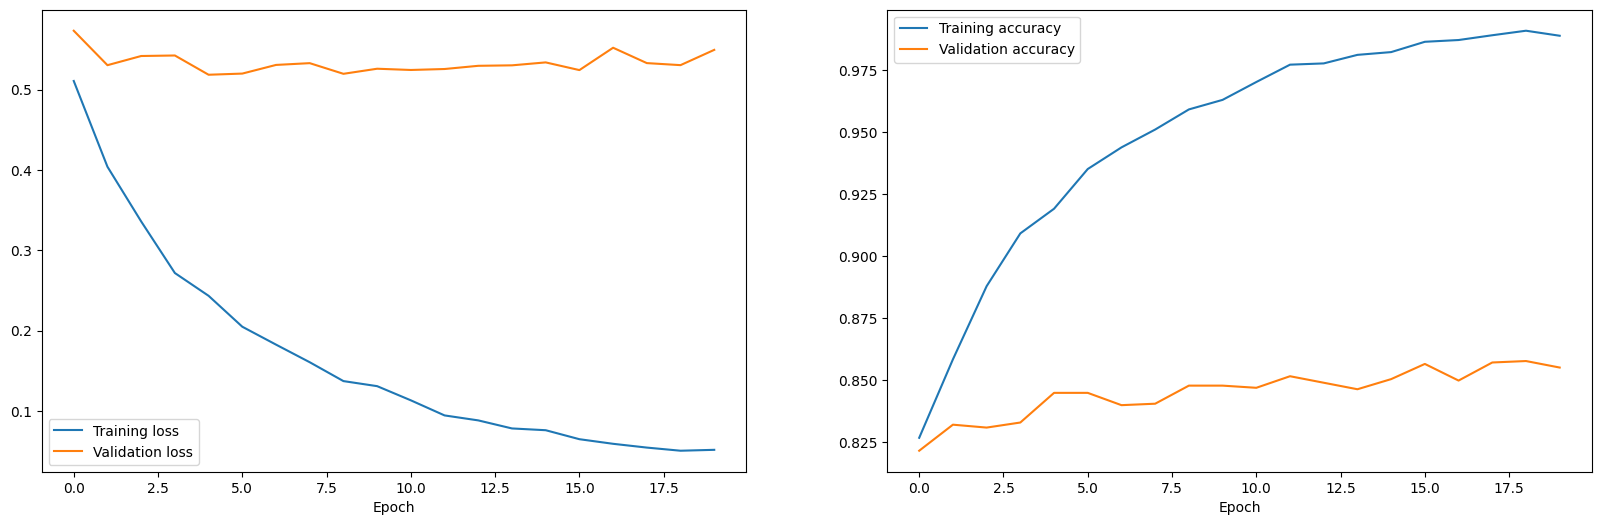

In [ ]:
# TODO 11 (required) - plot training history
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

sns.lineplot(x=range(len(hist_fine.history['loss'])), y=hist_fine.history['loss'], ax=axes[0], label='Training loss', estimator=None).set(xlabel='Epoch');
sns.lineplot(x=range(len(hist_fine.history['val_loss'])), y=hist_fine.history['val_loss'], ax=axes[0], label='Validation loss', estimator=None).set(xlabel='Epoch');


sns.lineplot(x=range(len(hist_fine.history['accuracy'])), y=hist_fine.history['accuracy'], ax=axes[1], label='Training accuracy').set(xlabel='Epoch');
sns.lineplot(x=range(len(hist_fine.history['val_accuracy'])), y=hist_fine.history['val_accuracy'], ax=axes[1], label='Validation accuracy').set(xlabel='Epoch');

## Evaluate model performance


Once you have finished training your model, use `evaluate` to get the model performance - loss and accuracy - on the evaluation set. (You should not use the evaluation set at all prior to this step.)

In [ ]:
model.evaluate(evaluation_gen)

105/105 [==============================] - 15s 143ms/step - loss: 0.4377 - accuracy: 0.8739


[0.4377260208129883, 0.8739169239997864]

We can also create a confusion matrix, to see which which classes are most often confused with one another.

In [ ]:
y_pred_prob = model.predict(evaluation_gen)
y_pred = np.argmax(y_pred_prob, axis=1)

105/105 [==============================] - 16s 140ms/step


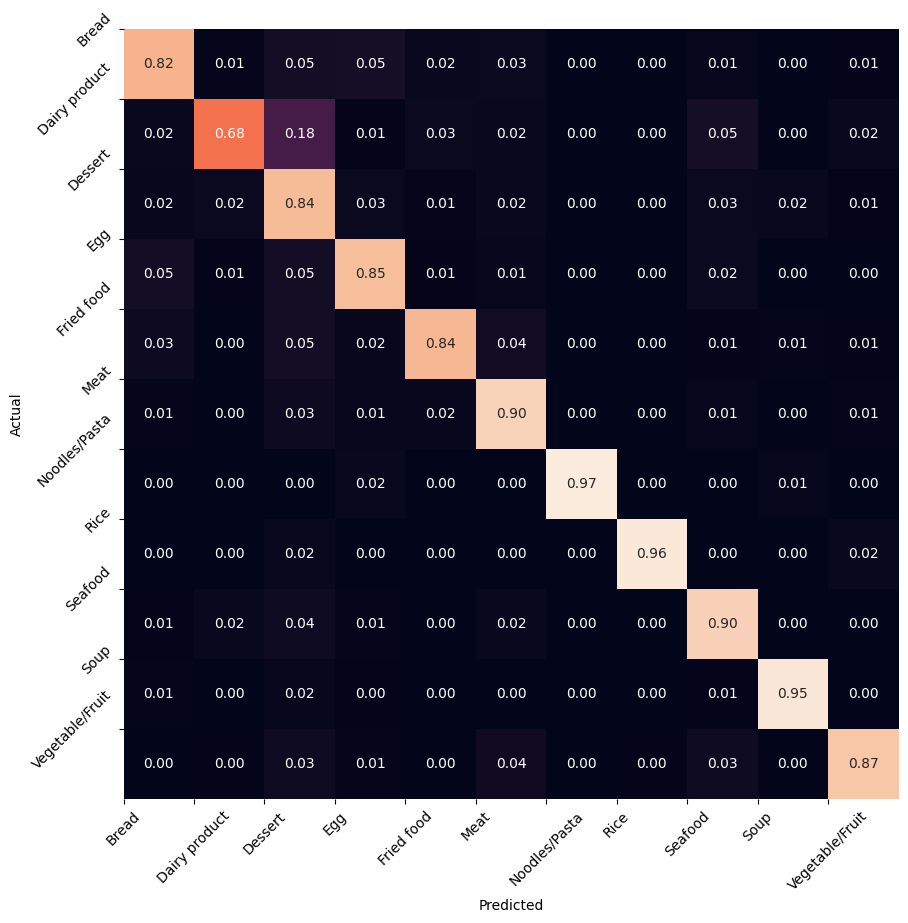

In [ ]:
cm = pd.crosstab(evaluation_gen.classes, y_pred,
                               rownames=['Actual'], colnames=['Predicted'],
                               normalize='index')
p = plt.figure(figsize=(10,10));
p = sns.heatmap(cm, annot=True, fmt=".2f", cbar=False);
p = plt.xticks(ticks=np.arange(0,11), labels=classes, rotation=45)
p = plt.yticks(ticks=np.arange(0,11), labels=classes, rotation=45)

## Save your model

Use the following cell to save your model:

In [ ]:
model.save("ResNet50V2_model.keras")

Then, download it for later use.

In [ ]:
from google.colab import files
files.download('ResNet50V2_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Use model on your own custom image

Take your own photograph of a food item in one of the 11 classes. Upload it to Colab, load it as a numpy array, and process the image (resize it, and scale so that each pixel takes on a value from 0 to 1).

Then, use the fitted model to get the per-class probabilities for each class.


Plot your image, and a bar plot showing the probability for the 5 most likely classes according to the model.

(You can refer to the "Classify with MobileNetV2" section of this week's notebook for an example.)

Saving egg.jpeg to egg.jpeg


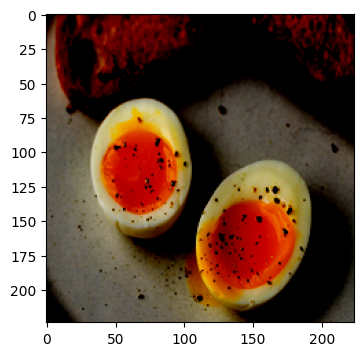

In [ ]:
# TODO 12 (required) - show example of model use on a new image
from google.colab import files
from PIL import Image
uploaded = files.upload()

filename = ''
for fn in uploaded.keys():
  filename = fn

INPUT_IMG_SIZE = 224

# pre-process image - using the predefined preprocessing function for ResNet
image = Image.open(filename).convert('RGB')
image_resized = image.resize((INPUT_IMG_SIZE, INPUT_IMG_SIZE), Image.BICUBIC)
image_array = tf.keras.preprocessing.image.img_to_array(image_resized);
image_array = np.expand_dims(image_array, axis=0);
test_sample = tf.keras.applications.resnet_v2.preprocess_input(image_array);

plt.figure(figsize=(4,4));
plt.imshow(test_sample.reshape(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3));

1/1 [==============================] - 0s 77ms/step


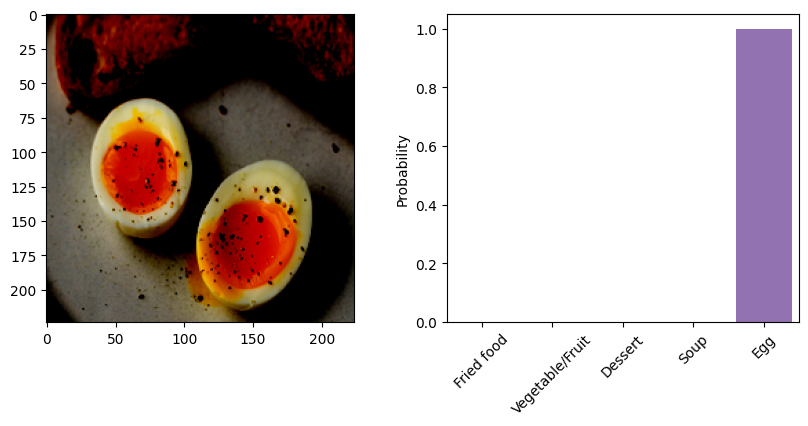

In [ ]:
test_probs = model.predict(test_sample)
most_likely_classes = np.argsort(test_probs.squeeze())[-5:]

plt.figure(figsize=(10,4));

plt.subplot(1,2,1);
plt.imshow(test_sample.reshape(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3));

plt.subplot(1,2,2)
p = sns.barplot(x=classes[most_likely_classes],y=test_probs.squeeze()[most_likely_classes]);
plt.ylabel("Probability");
p.set_xticklabels(p.get_xticklabels(), rotation=45);

## Describe your model - TODO 13 (required)

In the following cell, describe your final model and your results, by answering the following questions.

* **What base model did you use? How many parameters does this base model have?** <br>
I used the ResNet50V2 model with 23564800 parameters.

* **Describe the specific transformations you used to create an augmented data set.** <br>
[ResNet50V2's documentation](https://keras.io/api/applications/resnet/#resnet50v2-function) states that the model performs best when the input pixels are scaled from -1 to 1. So, the preprocessing function `keras.applications.resnet_v2.preprocess_input` was used to scale input images from -1
to 1.

* **For how many epochs did you train your classification head, and with what optimizer, learning rate, and batch size? What was the validation accuracy at the end of this training stage?** <br>
The classification head was trained with an EarlyStopping callback
function monitoring validation accuracy with patience of 3. This means that the model stopped training once the validation accuracy didn't increase for three consecutive epochs. <br>
"Adam" optimizer was used to train the model with the default learning rate (default learning rate is 0.001). Learning rate was the default learning rate of "Adam" optimizer, i.e. 0.001. A high learning rate of 0.001 was chosen since this is the first training of the model and we can have a larger learning rate. <br>
The validation accuracy at the end of this training stage was 80.96%.

* **Which layers did you un-freeze for fine-tuning, how many epochs did you fine-tune for, and what optimizer, learning rate, and batch size did you use for fine-tuning? What was the validation accuracy at the end of this training stage?** <br>
Only five layers from the base model were made trainable for fine-tuning since we don't want the model to lose essential learning from the ImageNet
dataset. <br>
* **What was your final accuracy on the evaluation set?** <br>
The final accuracy of the evaluation set was 87.39%.

* **Did your model correctly predict the class of your custom test image?** <br>
Yes, the model correctly predicted the egg's class.